<a href="https://colab.research.google.com/github/nonoumasy/Los-Angeles-Crime-2020/blob/master/Los_Angeles_Crime_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

Data Source: https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import re
import folium
from pandas import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly as py
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
#clean and prepare the data 

def clean_this(file_to_clean):
    '''
    cleans the file
    '''
    #load data into chunks since its a BIG file and then concat it back
    df = pd.read_csv(file_to_clean)
    
    #keep only relevant columns
    df = df[['DATE OCC','TIME OCC','AREA NAME', 'Crm Cd', 'Crm Cd Desc','Mocodes', 
             'Vict Age', 'Vict Sex','Vict Descent','Premis Desc','Weapon Desc',
             'Status Desc', 'LOCATION', 'LAT', 'LON']]
    
    #column cleanup
    df.columns = df.columns.str.lower().str.replace('\W+', '_').str.replace('(', '').str.replace(')', '')
    
    #change some columns to category type
    for col in df.select_dtypes(['object']):   
        df[col] = df[col].astype('category')
    
    #cleanup and process datatime data
    df.time_occ = df.time_occ.astype(str)
    df.time_occ = df.time_occ.str.zfill(4)
    df.time_occ = df.time_occ.str.ljust(6, fillchar='0')
    df.time_occ = df.time_occ.str.slice(0,2) + ':' + df.time_occ.str.slice(2,4) + ":" + df.time_occ.str.slice(4,6)
    
    #combine date and time and convert to datetime series
    df['date_occ'] = df['date_occ'].str.split(' ').str[0]
    df['date_time'] = df.date_occ + df.time_occ
    df.date_time = pd.to_datetime(df.date_time, format='%m/%d/%Y%H:%M:%S')
    
    #set date_time as index
    df.set_index('date_time', inplace=True)
    
    ## Create a violent crimes column. This is based on UCR Reporting pdf
    violent_crime_code = [110, 113, 121, 122, 815, 821, 210, 220, 230, 231, 236, 250, 251, 926, \
                      435, 436, 437, 622, 623, 624, 625, 626, 647, 763, 928, 930]
    df['violent_crime'] = df.crm_cd.isin(violent_crime_code).astype(int)

    #cleans up whitespaces on address
    df.location = df.location.str.lstrip().str.rstrip().str.strip()
    df.location = (df['location'].str.split()).str.join(' ')
    
    #replace race names using map
    race_dict = {'A' : 'Other Asian',
            'B' : 'Black', 
            'C' : 'Chinese', 
            'D' : 'Cambodian', 
            'F' : 'Filipino', 
            'G' : 'Guamanian', 
            'H' : 'Hispanic/Latin',
            'I' : 'AmerIndian/Alaskan',
            'J' : 'Japanese', 
            'K' : 'Korean', 
            'L' : 'Laotian', 
            'O' : 'Other', 
            'P' : 'Pacific Islander ',
            'S' : 'Samoan', 
            'U' : 'Hawaiian',
            'V' : 'Vietnamese', 
            'W' : 'White', 
            'X' : 'Unknown', 
            'Z' : 'Asian Indian'}

    df['vict_descent'] = df['vict_descent'].map(race_dict)
    
    #find age outliers and normalized
    for val in range(int(86.0),int(119.0)):
        df.vict_age.replace(val, np.nan, inplace=True)
    
    df.vict_age.replace(0.0, np.nan, inplace=True)
    
    #drop unnecessary columns
    df.drop(['date_occ', 'time_occ'], axis=1, inplace=True)
    
    return df

In [3]:
df = clean_this('https://data.lacity.org/api/views/2nrs-mtv8/rows.csv?accessType=DOWNLOAD')

In [9]:
# last 3 months
last_3m_df = df[df.index > '2020-04-11']

In [11]:
#
last_3m_df.violent_crime.value_counts()

0    30997
1    13752
Name: violent_crime, dtype: int64

In [12]:
# last 3 months
last_3m_df.crm_cd_desc.value_counts(normalize=True, ascending=False)[:5]

VEHICLE - STOLEN                                           0.119533
BATTERY - SIMPLE ASSAULT                                   0.083957
BURGLARY                                                   0.074683
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    0.070482
BURGLARY FROM VEHICLE                                      0.064381
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             0.062906
INTIMATE PARTNER - SIMPLE ASSAULT                          0.057208
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)            0.053409
THEFT PLAIN - PETTY ($950 & UNDER)                         0.047956
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                   0.036716
Name: crm_cd_desc, dtype: float64

In [ ]:
# create a new dataframe of only violent crimes
violent_df = df[df.violent_crime == 1]

In [ ]:
violent_df.head()

,area_name,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_desc,weapon_desc,status_desc,location,lat,lon,violent_crime
date_time,,,,,,,,,,,,,,
2020-01-08 22:30:00,Southwest,624,BATTERY - SIMPLE ASSAULT,0444 0913,36.0,F,Black,SINGLE FAMILY DWELLING,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,1100 W 39TH PL,34.0141,-118.2978,1
2020-01-01 03:30:00,Central,624,BATTERY - SIMPLE ASSAULT,0416 1822 1414,25.0,M,Hispanic/Latin,SIDEWALK,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S HILL ST,34.0459,-118.2545,1
2020-01-01 05:10:00,Central,626,INTIMATE PARTNER - SIMPLE ASSAULT,1414 1218 2000 1814 0416 0447,53.0,F,Black,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)","STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,300 E 5TH ST,34.0449,-118.2458,1
2020-01-01 00:30:00,Central,121,"RAPE, FORCIBLE",0413 1822 1262 1415,25.0,F,Hispanic/Latin,NIGHT CLUB (OPEN EVENINGS ONLY),UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S BROADWAY,34.0452,-118.2534,1
2020-01-04 09:00:00,Central,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 0417 1218 1814 2004,61.0,M,White,SIDEWALK,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,ALISO,34.0554,-118.2406,1


# Pandas Profiling

In [ ]:
pd.__version__

'0.25.0'

In [ ]:
ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,16
Number of observations,47252
Total Missing (%),12.5%
Total size in memory,4.0 MiB
Average record size in memory,88.2 B
Numeric,4
Categorical,10
Boolean,1
Date,1
Text (Unique),0
Rejected,0


# Exploratory Data Analysis (EDA)

For analyzing crime data

Target Profile Analysis, also known as victim profile analysis, is an attempt to identify the type of person, structure, vehicle or establishment most likely to be attacked by a suspect. 


The task of analyzing data and drawing conclusions from them is, much like putting a jig·saw puzzle together. The analyst is working with many data elements that have been gathered from a wide variety of sources. The goal is to combine the data so that a true "picture" of criminal activity can be determined. These pictures manifest themselves in the form of crime patterns. As described below, they are of two types: 

Geographic concentration patterns refer to patterns identified on the basis of: 
• similarity of crime type (e.g., commercial burglary),• multiple occurrences in well-defined geographic areas. 

Specific and recurring MO patterns refer to patterns identified on the basis of: 
• similarity of suspect and/or suspect vehicle descrip.. tion(s) 
• unique MO characteristics. 


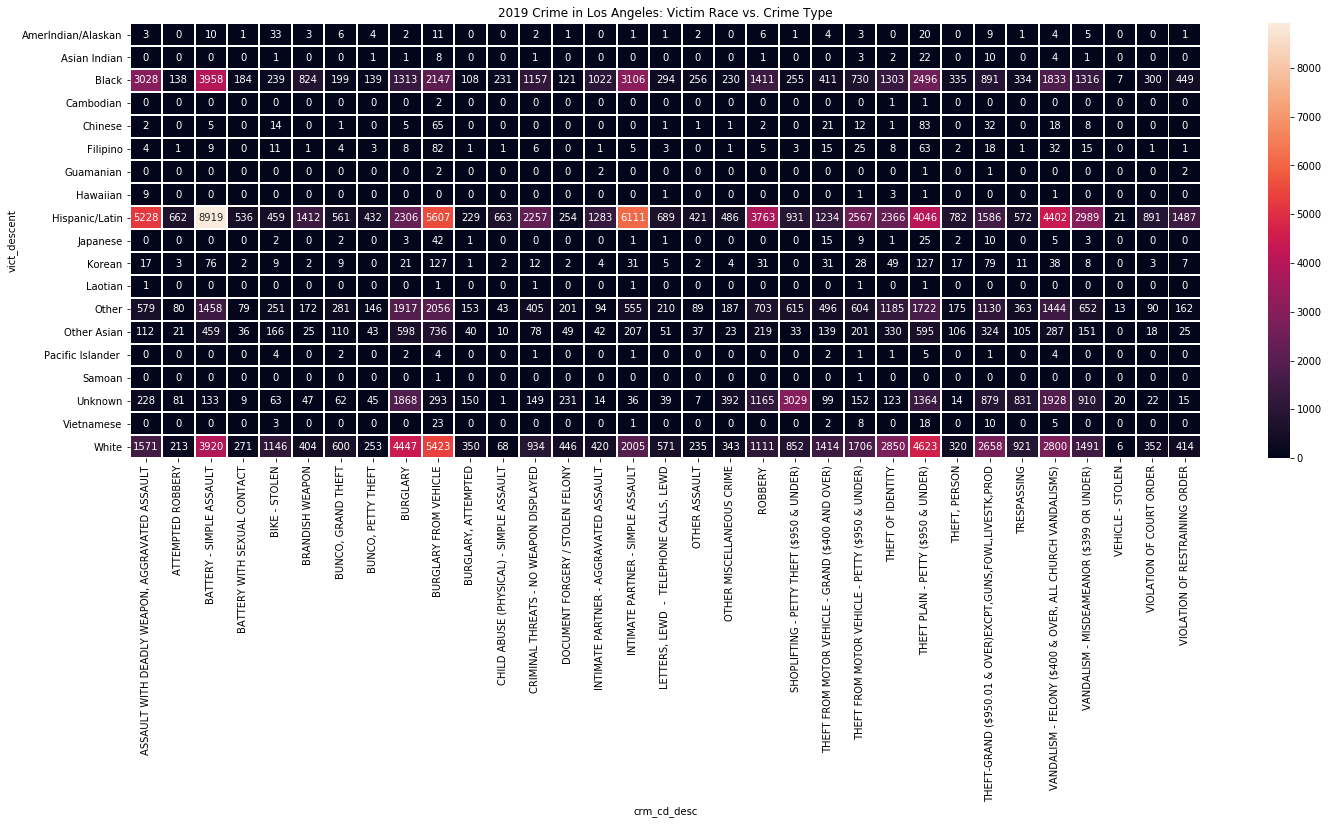

In [ ]:
race_tab = pd.crosstab(index = violent_df_most_freq.vict_descent, columns=violent_df_most_freq.crm_cd_desc)
plt.figure(figsize=(24,8))
plt.title('2019 Crime in Los Angeles: Victim Race vs. Crime Type')
sns.heatmap(race_tab,
            fmt="d",
            linewidths=1,
            annot=True,
            )

In [ ]:
df.describe()

,crm_cd,vict_age,lat,lon
count,2.028334e+06,1.667174e+06,2.028334e+06,2.028334e+06
mean,5.070086e+02,3.821345e+01,3.406333e+01,-1.183072e+02
std,2.105026e+02,1.563340e+01,7.234703e-01,2.482409e+00
min,1.100000e+02,-9.000000e+00,0.000000e+00,-1.188279e+02
25%,3.300000e+02,2.600000e+01,3.401020e+01,-1.184366e+02
50%,4.410000e+02,3.600000e+01,3.406240e+01,-1.183295e+02
75%,6.260000e+02,4.900000e+01,3.417580e+01,-1.182780e+02
max,9.560000e+02,8.500000e+01,3.479070e+01,0.000000e+00


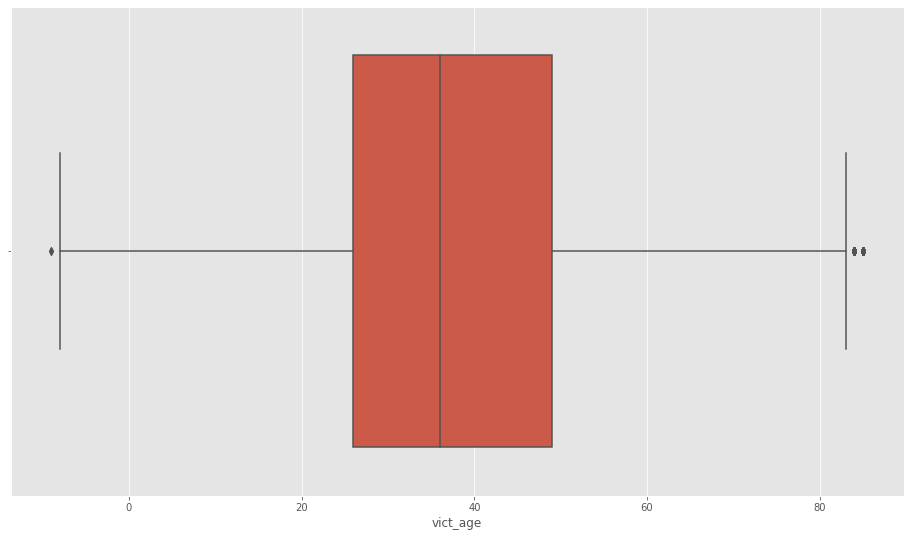

In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(x=df.vict_age)

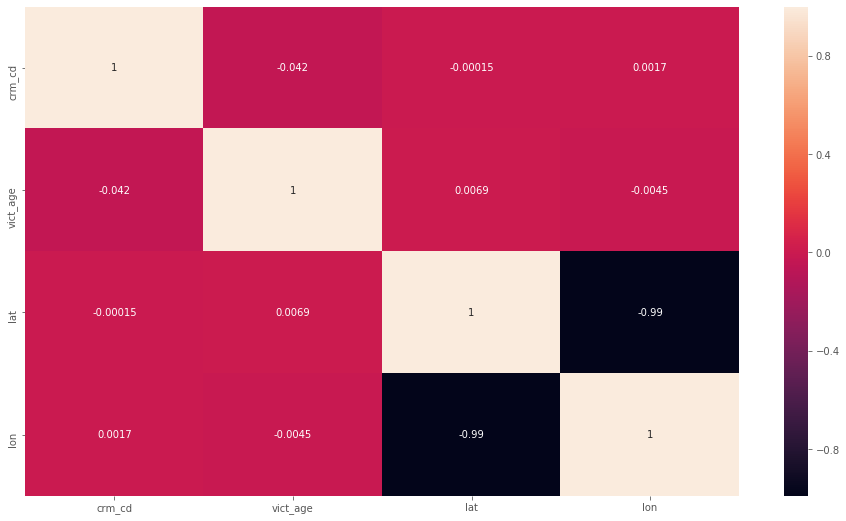

In [ ]:
#correlation between the data
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True)

In [ ]:
#what type of crime is most prevalent?
df.crm_cd_desc.value_counts(dropna=True)[:5]

BATTERY - SIMPLE ASSAULT              174932
BURGLARY FROM VEHICLE                 148665
VEHICLE - STOLEN                      147517
BURGLARY                              137460
THEFT PLAIN - PETTY ($950 & UNDER)    137145
Name: crime_code_description, dtype: int64

In [ ]:
#what type of crime is least prevalent?
df.crm_cd_desc.value_counts()[-5:]

BLOCKING DOOR INDUCTION CENTER              3
TILL TAP - ATTEMPT                          3
FIREARMS RESTRAINING ORDER (FIREARMS RO)    2
TRAIN WRECKING                              2
DRUNK ROLL - ATTEMPT                        1
Name: crime_code_description, dtype: int64

In [ ]:
#where was there most crime?
df.area_name.value_counts().[:5]

77th Street    131722
Southwest      122674
N Hollywood    103320
Pacific        100906
Southeast      100288
Name: area_name, dtype: int64

In [ ]:
#where was there least crime?
df.area_name.value_counts()[-5:]

Rampart       80521
West LA       80127
Wilshire      78481
Foothill      72360
Hollenbeck    70000
Name: area_name, dtype: int64

In [ ]:
#Where did most murders occured?
df[df.crm_cd_desc == 'CRIMINAL HOMICIDE'].area_name.value_counts()[:5]

Pacific      0
Northeast    0
Newton       0
Hollywood    0
Central      0
Name: area_name, dtype: int64

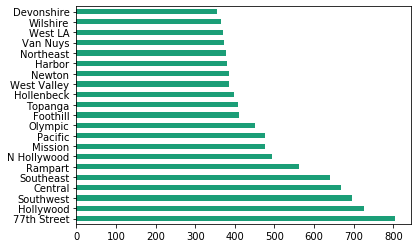

In [ ]:
#Where did most Rapes occured?
df[df.crm_cd_desc == 'RAPE, FORCIBLE'].area_name.value_counts().plot(kind='barh', cmap='Dark2')

In [ ]:
#Where did most robbery occured?
df[df.crm_cd_desc == 'ROBBERY'].area_name.value_counts()

77th Street    9303
Southeast      7338
Southwest      6725
Newton         6328
Rampart        5076
Olympic        4800
Central        4524
Hollywood      3840
Wilshire       2853
Mission        2843
Hollenbeck     2576
Northeast      2499
Harbor         2334
Pacific        2304
N Hollywood    2176
Van Nuys       1912
West Valley    1882
Topanga        1878
Foothill       1829
Devonshire     1603
West LA        1437
Name: area_name, dtype: int64

In [ ]:
#Crime by year
print('Crime by year')
print(df.index.year.value_counts())
print()

Crime by year
2010    100
Name: date_time, dtype: int64



In [ ]:
#Crime by day of week
print('Crime by day of week')
print(df.index.dayofweek.value_counts().sort_index())
print()

Crime by day of week
0    300971
1    295200
2    298417
3    296966
4    324383
5    303736
6    290545
Name: date_time, dtype: int64



In [ ]:
#Crime by day of hour
print('Crime by hour')
print(df.index.hour.value_counts()[:5])
print()

Crime by hour
20    11
0      9
1      9
2      7
15     7
Name: date_time, dtype: int64



In [ ]:
# Top 5 crimes against women
print('Main Crime type against women')
print(df[df['vict_sex'] == 'F' ].crm_cd_desc.value_counts()[:5])
print()

Main Crime type against women
BATTERY - SIMPLE ASSAULT                          11
INTIMATE PARTNER - SIMPLE ASSAULT                  7
VANDALISM - MISDEAMEANOR ($399 OR UNDER)           3
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT     2
BURGLARY FROM VEHICLE                              2
Name: crm_cd_desc, dtype: int64



In [ ]:
# Top 5 crimes against men
print('Main Crime type against men')
print(df[df['vict_sex'] == 'M' ].crm_cd_desc.value_counts()[:5])
print()

Main Crime type against women
BATTERY - SIMPLE ASSAULT              64170
BURGLARY FROM VEHICLE                 62490
BURGLARY                              62083
THEFT PLAIN - PETTY ($950 & UNDER)    58009
THEFT OF IDENTITY                     46877
Name: crime_code_description, dtype: int64



In [ ]:
# Murder Victims by gender
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].vict_sex.value_counts()[:5]

M    1774
F     280
X       1
Name: victim_sex, dtype: int64

In [ ]:
# Murder Victims by gender
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].victim_descent.value_counts()[:5]

H    990
B    804
W    179
O     52
A     23
Name: victim_descent, dtype: int64

In [ ]:
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].victim_age.value_counts().head()

20.0    88
19.0    81
23.0    77
26.0    73
25.0    73
Name: victim_age, dtype: int64

In [ ]:
# Murder Victims by age
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].premis_desc.value_counts()[:5]

STREET                                          878
SIDEWALK                                        573
SINGLE FAMILY DWELLING                          259
MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)    251
PARKING LOT                                     154
Name: premis_desc, dtype: int64

In [ ]:
#pivot table
df.pivot_table(index='victim_descent',
               columns='vict_sex',
               values='victim_age',
               aggfunc='sum',
              fill_value=0)

victim_sex,-,F,H,M,N,X
victim_descent,,,,,,
AmerIndian/Alaskan,0,6266,0,13767,0,0
Asian Indian,0,676,0,1082,0,0
Black,0,5077478,88,3895812,0,45
Cambodian,0,160,0,266,0,0
Chinese,0,10477,0,10679,0,0
Filipino,47,38395,215,33855,0,23
Guamanian,0,1229,0,578,0,0
Hawaiian,0,1920,0,1889,0,0
Hispanic/Latin,0,8631289,801,8534050,61,192


In [ ]:
# Murder Victims by gender
df[df['crm_cd_desc'] == 'RAPE, FORCIBLE' ].area_name.value_counts()[:5]

77th Street    777
Hollywood      704
Southwest      665
Central        627
Southeast      609
Name: area_name, dtype: int64

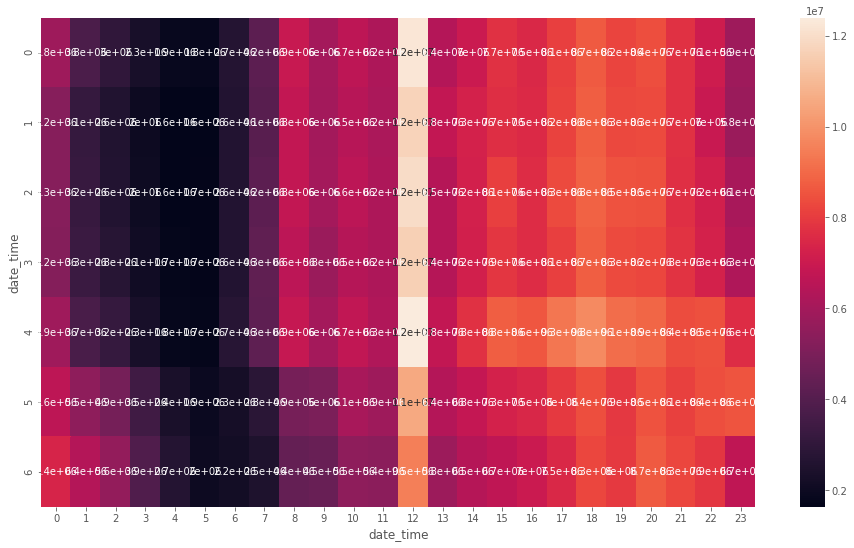

In [ ]:
#plot of serious crimes -  hour vs. day_of_week
data = df.groupby([df.index.dayofweek, df.index.hour]).crm_cd.sum().unstack()
plt.figure(figsize=(16,9))         # Sample figsize in inches
sns.heatmap(data, annot=True)

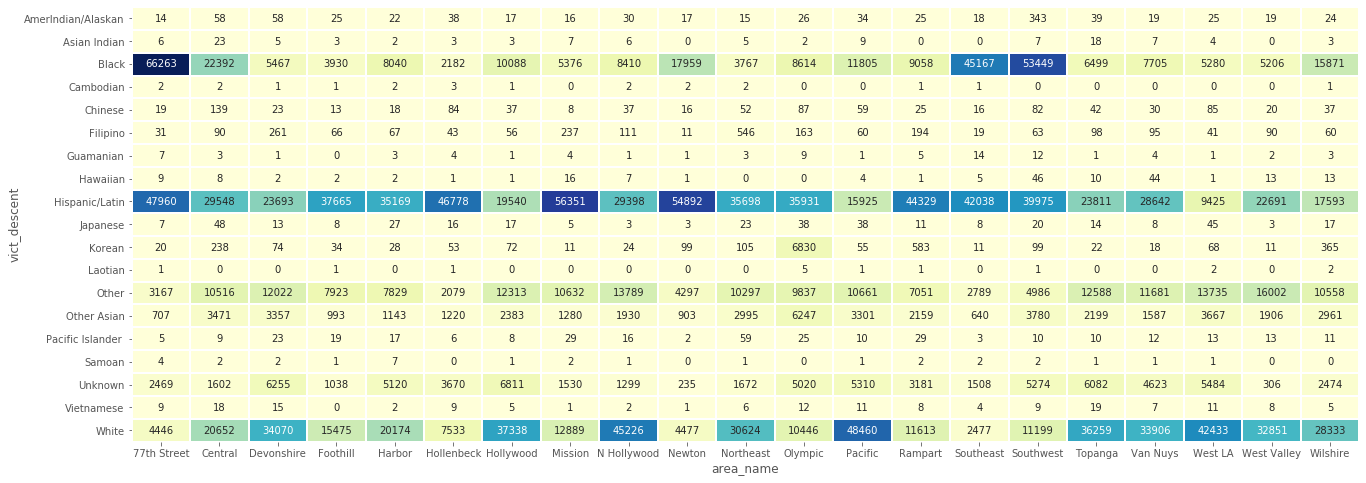

In [ ]:
cross_tab = pd.crosstab(df.vict_descent, df.area_name)
fig, ax = plt.subplots(figsize=(22,8))         # Sample figsize in inches
sns.heatmap(cross_tab,
            cmap="YlGnBu",
            annot=True,
            fmt="d",
            linewidths=1,
            cbar=False,
            ax=ax)

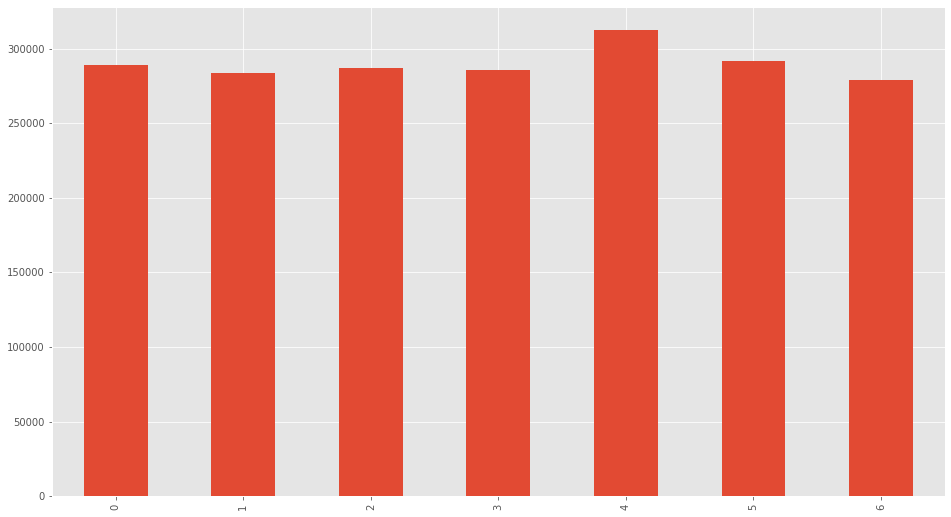

In [ ]:
#When did most crimes occured in terms of days of the week?
plt.figure(figsize=(16,9))
df.index.dayofweek.value_counts().sort_index().plot(kind='bar')

In [ ]:
#victims by gender
print(df.vict_sex.value_counts())
print()

#victims by race
print(df.vict_descent.value_counts())
print()

#victims by age
print('victims by avg age')
df.vict_age= df.vict_age.abs()
print(df.vict_age.mean())
print()


M    936172
F    854338
X     48801
H        67
N        17
-         1
Name: vict_sex, dtype: int64

Hispanic/Latin        697052
White                 490881
Black                 322528
Other                 194752
Unknown                70963
Other Asian            48829
Korean                  8820
Filipino                2402
Chinese                  929
AmerIndian/Alaskan       882
Japanese                 372
Pacific Islander         329
Hawaiian                 186
Vietnamese               162
Asian Indian             113
Guamanian                 80
Samoan                    31
Cambodian                 21
Laotian                   15
Name: vict_descent, dtype: int64

victims by avg age
38.214738833499084



In [ ]:
#victims by gender and crime
print('Main crime incidents on Women')
print(df[df['vict_sex'] == 'F'].crm_cd_desc.value_counts()[:5])
print()
print('Main crime incidents on Men')
print(df[df['vict_sex'] == 'M'].crm_cd_desc.value_counts()[:5])
print()



Main crime incidents on Women
BATTERY - SIMPLE ASSAULT              95496
INTIMATE PARTNER - SIMPLE ASSAULT     87827
BURGLARY FROM VEHICLE                 69452
THEFT PLAIN - PETTY ($950 & UNDER)    63662
THEFT OF IDENTITY                     61475
Name: crm_cd_desc, dtype: int64

Main crime incidents on Men
BATTERY - SIMPLE ASSAULT                          87784
BURGLARY FROM VEHICLE                             85746
BURGLARY                                          80433
THEFT PLAIN - PETTY ($950 & UNDER)                75203
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    64175
Name: crm_cd_desc, dtype: int64



Main crime incidents on Korean women between 20 and 30 years old in 2018


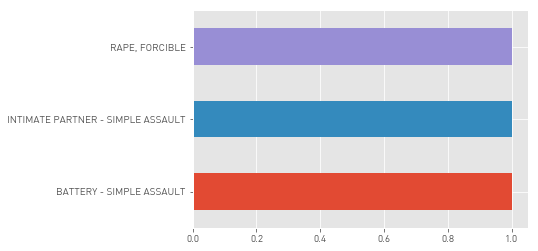

In [ ]:
print('Main crime incidents on Korean women between 20 and 30 years old in 2018')
df[(df['victim_age'] >= 20)   
 & (df['victim_age'] <= 30) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'Korean')
 & (df['year'] == 2018)].crm_cd_desc.value_counts().plot(kind='barh')


Main crime incidents on Japanese women between 20 and 40 years old in 2018


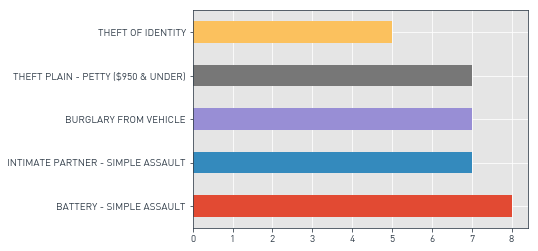

In [ ]:
print('Main crime incidents on Japanese women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'Japanese')].crm_cd_desc.value_counts()[:5].plot(kind='barh')


In [ ]:
print('Main crime incidents on White women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'White')].crm_cd_desc.value_counts()[:5]


Main crime incidents on White women between 20 and 40 years old in 2018


Rape incidents on White women between 20 and 40 years old in 2018


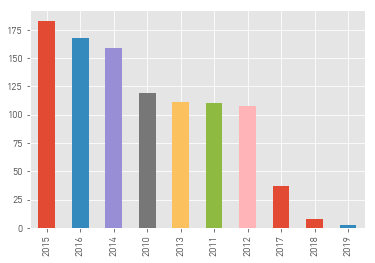

In [ ]:
print('Rape incidents on White women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'White')
 & (df['crm_cd_desc'] == 'RAPE, FORCIBLE')].year.value_counts().plot(kind='bar')

Main crime incidents on Black women between 20 and 40 years old in 2018


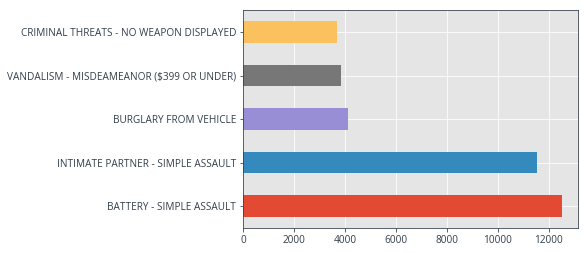

In [ ]:
print('Main crime incidents on Black women between 20 and 40 years old in 2018')
df[(df['victim_age'] > 20)   
 & (df['victim_age'] < 40) 
 & (df['vict_sex'] == 'F')
 & (df['victim_descent'] == 'Black')].crm_cd_desc.value_counts()[:5].plot(kind='barh')


In [ ]:
print('Main crime incidents on victims over 60 years old')
df[(df['victim_age'] < 60)].crm_cd_desc.value_counts()[:5]


Main crime incidents on victims over 60 years old


BATTERY - SIMPLE ASSAULT              127241
BURGLARY FROM VEHICLE                 105697
THEFT PLAIN - PETTY ($950 & UNDER)     92740
BURGLARY                               86491
INTIMATE PARTNER - SIMPLE ASSAULT      78932
Name: crime_code_description, dtype: int64

In [ ]:
#Is crime increasing or decreasing in time?
df.datetime_series.dt.year.value_counts().sort_index()[0:9]

2010    208753
2011    200384
2012    201094
2013    192128
2014    194903
2015    214686
2016    224445
2017    229531
2018    224745
Name: datetime_series, dtype: int64

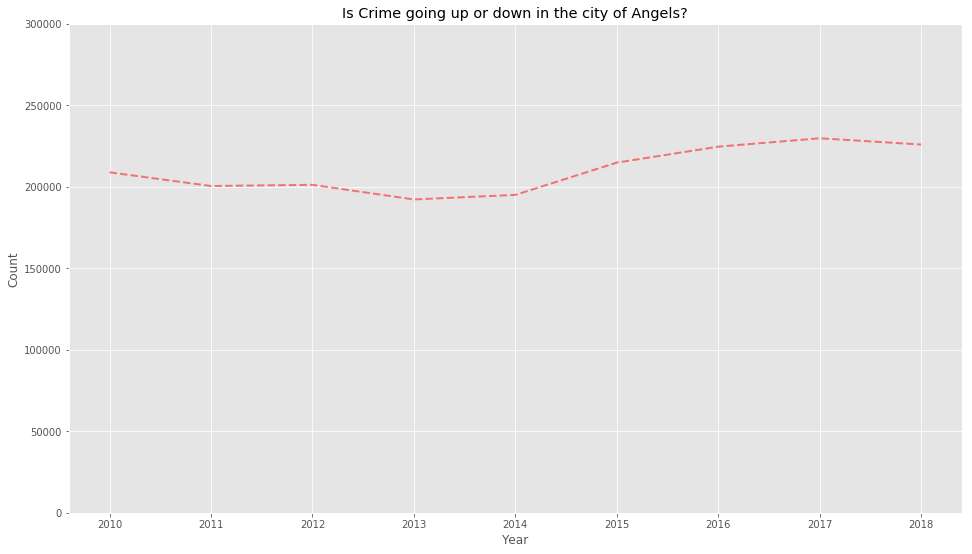

In [ ]:
#Is crime increasing or decreasing in time? Show
trend = df.date_time.dt.year.value_counts().sort_index()[0:9]
plt.figure(figsize=(16,9))
plt.plot(trend, alpha=0.5, color='r' , linewidth=2, linestyle='--' )
plt.ylim(0,300000)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Is Crime going up or down in the city of Angels?')
plt.show()

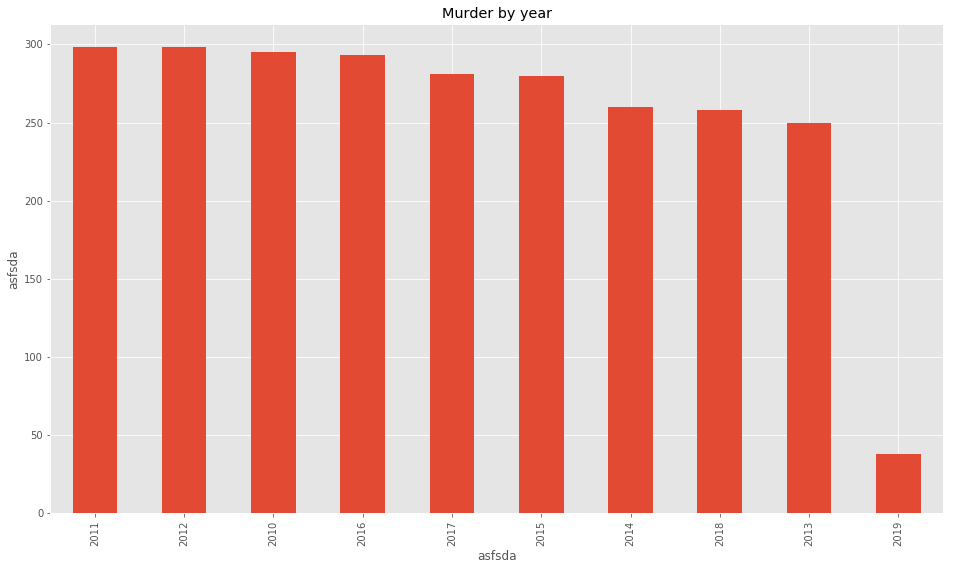

In [ ]:
#murder by year
df[df['crm_cd_desc'] == 'CRIMINAL HOMICIDE' ].year.value_counts().plot(figsize=(16,9), kind='bar')
plt.xlabel('asfsda')
plt.ylabel('asfsda')
plt.title('Murder by year')
plt.show()


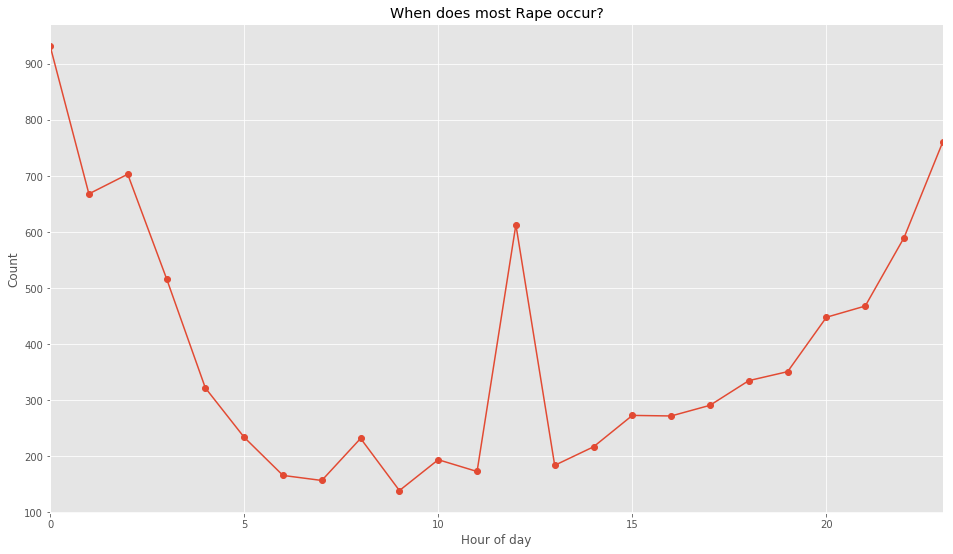

In [ ]:
# When does most Rape occur?
df[df['crm_cd_desc'] == 'RAPE, FORCIBLE' ].date_time.dt.hour.value_counts().sort_index().plot(figsize=(16,9), marker='o')
plt.xlabel('Hour of day')
plt.ylabel('Count')
plt.title('When does most Rape occur?')
plt.show()

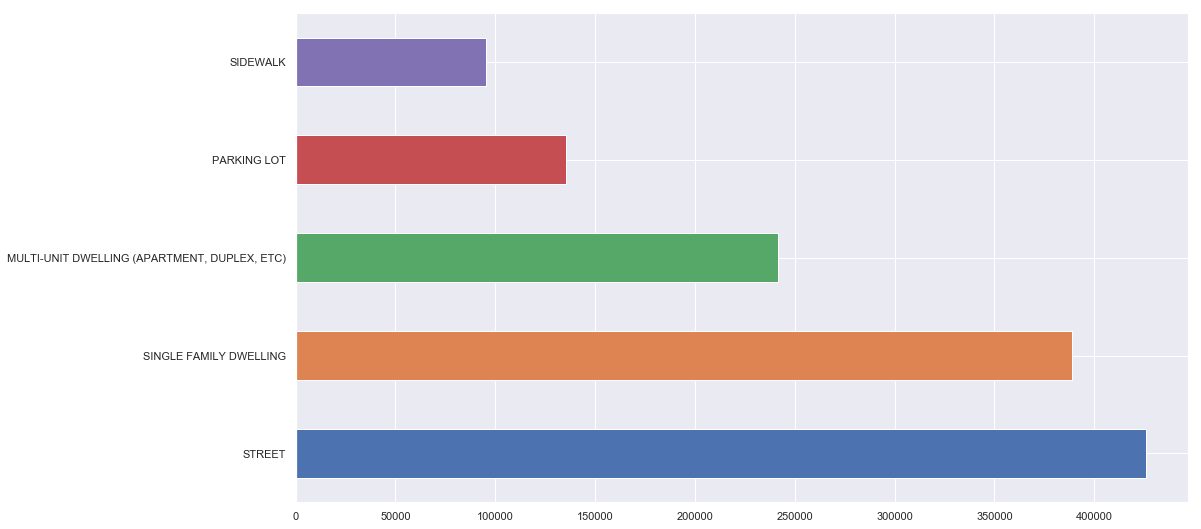

In [ ]:
#where did crime incidents occur?
df.premise_description.value_counts()[:5].plot(kind='barh', figsize=(16,9))

In [ ]:
#Victim by age
df.victim_age.value_counts().sort_index().plot(figsize=(16,9),marker='o', colormap='Dark2')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Victim by age')
plt.show()

AttributeError: ignored

In [ ]:
pd.pivot_table(violent_2019_df,
               index= ['area_name'],
               columns=['month'],
               values='violent_crime',
               aggfunc='sum').style.background_gradient(cmap='Reds', axis=0)

month,1,2,3,4,5,6,7,8,9,10,11,12
area_name,,,,,,,,,,,,
77th Street,235,192,231,206,280,236,216,230,192,191,205,194
Central,238,216,226,207,252,283,235,276,259,247,220,219
Devonshire,104,69,87,104,110,112,116,106,116,124,89,95
Foothill,95,83,114,88,109,105,109,140,88,108,94,105
Harbor,92,85,130,115,132,127,129,171,135,153,128,116
Hollenbeck,117,104,139,130,130,127,146,123,120,138,129,128
Hollywood,156,107,144,151,162,173,184,149,169,176,129,137
Mission,117,119,159,114,113,130,159,120,129,121,109,109
N Hollywood,112,132,132,117,122,161,165,140,124,148,124,121


In [ ]:
plot = px.histogram(violent_df,
                    x='area_name',
                    color='area_name',
                    animation_frame= violent_df.index.year,
                    title='LA Violent Crimes 2020',
                   )

plot.layout.showlegend = False
plot.show()

# Time Series Analysis

The findings from an analysis I did for LA Crime 2010-2019 show that all major crime rates exhibit seasonal behavior, and that most follow similar cycles. The existence of seasonal patterns is not explainable by monthly temperature differences between areas, but seasonality and temperature variations do interact with each other. These findings imply that seasonal fluctuations have both environmental and social components, which can combine to create different patterns from one location to another(see reference 3).




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


yhat          -53.369179
yhat_lower   -231.616736
yhat_upper    125.441522
dtype: float64


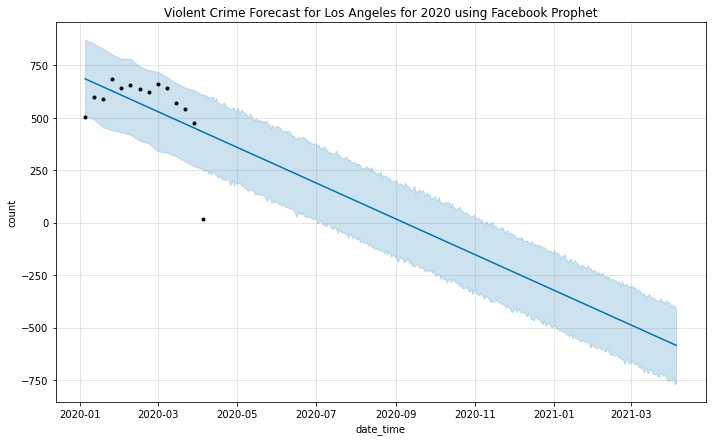

In [ ]:
import pandas as pd
from fbprophet import Prophet

violent_df['date_time'] = violent_df.index

# preprocess for forecasting
forecast_df = violent_df[['date_time', 'violent_crime']]
forecast_df.columns = ['ds', 'y']
forecast_df.set_index('ds', drop=True, inplace=True)
forecast_df = forecast_df.resample('W').sum()
forecast_df.reset_index(inplace=True)


m = Prophet()
m.fit(forecast_df)
future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
fig1 = m.plot(forecast)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].mean())

plt.xlabel('date_time')
plt.ylabel('count')
plt.title('Violent Crime Forecast for Los Angeles for 2020-2021 using Facebook Prophet');

# Geospatial Analysis


In [ ]:
#dualmap of crime in LA

from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

m = folium.Map(
    location=[34.127141, -118.29008],
    zoom_start=8,
    min_zoom=10,
    tiles='cartodbpositron',

)

folium.plugins.Fullscreen(position='bottomright').add_to(m)


HeatMap(violent_df[['lat', 'lon']].values.tolist(), radius=10, name=2019).add_to(m)


m.save('map.html')
m

In [ ]:
from pyproj import CRS
crs = CRS("WGS84")

# load LA neighborhood shapefile
gdf = gpd.read_file('Los Angeles Neighborhood Map.geojson', crs=crs)
gdf.crs

# create new gdf
geometry = gpd.points_from_xy(violent_2019_df.lon.astype('float'), violent_2019_df.lat.astype('float'))
new_gdf = gpd.GeoDataFrame(violent_2019_df, crs=crs, geometry=geometry)

#drop bad values
new_gdf.drop(new_gdf[new_gdf.lon == '0.0'].index, axis=0, inplace=True)

#merge points to polygons
merged_gdf = gpd.sjoin(gdf, new_gdf, op='contains')

# group violent crimes by name so we can get aggregate values
groupby_df = (merged_gdf.groupby(['name'])['violent_crime'].sum()).to_frame()
temp_df = merged_gdf[['name', 'geometry']].drop_duplicates()
hello_df = pd.merge(temp_df, groupby_df, left_on='name', right_on='name')

#load geojson of los angeles county shapefiles by zipcodes
with open('Los Angeles Neighborhood Map.geojson', 'r') as file:
  temp_json = file.read()

geojson = json.loads(temp_json)

#plot the map!
fig = px.choropleth(data_frame=hello_df,
                    geojson=geojson,
                    color='violent_crime',
                    locations='name',
                    featureidkey='properties.name',
                    color_continuous_scale='blues',
                    projection="mercator",
                    title='Los Angeles Violent Crimes 2019 by Neighborhood',
                    width=1200,
                    height=1200,
                    )


fig.update_geos(fitbounds="locations", visible=False)
fig.update(layout_coloraxis_showscale=False)
py.offline.plot(fig, filename = 'index.html', auto_open=False)

fig.show(showlegend=False)

# Data Source


1.  Dataset : https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8
2.  MO Code : https://data.lacity.org/api/views/63jg-8b9z/files/3db69cd3-446c-4dcd-82eb-3436dc08d3be?download=true&filename=MO_CODES_Numerical_20180627.pdf
3. https://data.lacity.org/api/views/63jg-8b9z/files/131cdc45-bfbc-433f-b370-deeb3efeb5ff?download=true&filename=ucr_handbook_2013.pdf
4. https://data.lacity.org/api/views/63jg-8b9z/files/fff2caac-94b0-4ae5-9ca5-d235b19e3c44?download=true&filename=UCR-COMPSTAT062618.pdf




# References:
1. LAPD Crime 
    http://www.lapdonline.org/inside_the_lapd/content_basic_view/27333
    
2. Crime Classification Grouping:
    https://www.nap.edu/read/23492/chapter/7#128

3. Seasonal Cycles in Crime, and Their Variability, https://www.jstor.org/stable/43551937?seq=1
4. Seasonal Patterns in Criminal Victimization Trends, https://www.bjs.gov/content/pub/pdf/spcvt.pdf
5. IS CRIME SEASONAL? , https://bjs.gov/content/pub/pdf/ics.pdf
